### Multi-input Autoencoder model on CTG dataset
- Load Data
- Preprocess Data
- Perform PCA on Data
- Divide Dataset in 2 smaller datasets of fewer features
- Define Multi-input Autoencoder Model
- Train Model
- Generate predictions for Train and Test Sets
- Perform PCA on Encoded Data
- Evaluate generated data on classification models

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Data
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')

In [6]:
# Preprocess Data
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [7]:
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))

In [8]:
# Divide the dataset into 2 subsets with fewer features, approximately in half.
X_train_first = X_train_norm.iloc[:,:11]
X_train_second = X_train_norm.iloc[:,11:]
X_test_first = X_test_norm.iloc[:,:11]
X_test_second = X_test_norm.iloc[:,11:]

In [13]:
print(X_train_first.shape[1])

11


_____________________________
### PCA

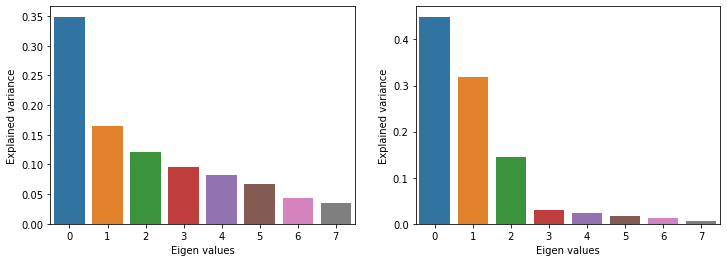

Simple PCA explained variance ratio: 0.9576117749294565
Simple PCA explained variance ratio: 0.9982023743654905


In [10]:
# Perform PCA to find the most significant features
from sklearn.decomposition import PCA
# select the number of components
pca_first = PCA(n_components = 8)
X_train_pca_first = pca_first.fit_transform(X_train_first)
X_test_pca_first = pca_first.transform(X_test_first)

pca_second = PCA(n_components = 8)
X_train_pca_second = pca_second.fit_transform(X_train_second)
X_test_pca_second = pca_second.transform(X_test_second)

x_pca_train_first_labeled = np.c_[X_train_pca_first , y_train]
x_pca_test_first_labeled = np.c_[X_test_pca_first , y_test]
x_pca_train_second_labeled = np.c_[X_train_pca_second , y_train]
x_pca_test_second_labeled = np.c_[X_test_pca_second , y_test]


plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1,2,1)
sns.barplot(np.arange(np.shape(pca_first.explained_variance_ratio_)[0]),pca_first.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")

ax1 = plt.subplot(1,2,2)
sns.barplot(np.arange(np.shape(pca_second.explained_variance_ratio_)[0]),pca_second.explained_variance_ratio_)
plt.xlabel("Eigen values")
plt.ylabel("Explained variance")
plt.show()

print(f"Simple PCA explained variance ratio: {pca_first.explained_variance_ratio_.sum()}")
print(f"Simple PCA explained variance ratio: {pca_second.explained_variance_ratio_.sum()}")


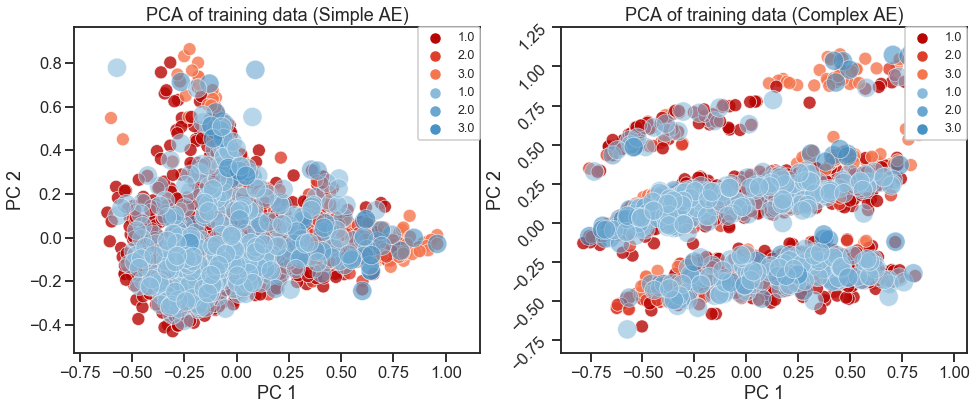

In [11]:
sns.set_style("white")
sns.set_context("talk")
sns.set_style("ticks")
ax1 = plt.subplot(1,2,1)
sns.scatterplot(x=x_pca_train_first_labeled[:,0], 
                y=x_pca_train_first_labeled[:,1], 
                alpha = 0.8, 
                s= 170, legend='full', 
                hue=x_pca_train_first_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=x_pca_test_first_labeled[:,0],
                y=x_pca_test_first_labeled[:,1],
                alpha = 0.6, 
                s= 370, 
                legend='full',
                hue=x_pca_test_first_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of training data (Simple AE)")

ax1 = plt.subplot(1,2,2)
sns.scatterplot(x=x_pca_train_second_labeled[:,0], 
                y=x_pca_train_second_labeled[:,1], 
                alpha = 0.8, 
                s= 170, legend='full', 
                hue=x_pca_train_second_labeled[:,-1],
                palette=sns.color_palette("OrRd")[:2:-1])
sns.scatterplot(x=x_pca_test_second_labeled[:,0],
                y=x_pca_test_second_labeled[:,1],
                alpha = 0.6, 
                s= 370, 
                legend='full',
                hue=x_pca_test_second_labeled[:,-1], 
                palette=sns.color_palette("Blues_d")[:2:-1])
ax1.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.,framealpha=1, frameon=True, fontsize="x-small")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.figure.set_size_inches( (16,6) )
ax1.set_title("PCA of training data (Complex AE)")

plt.yticks(rotation=45) 
plt.show()

__________________________________________
### Autoencoder

In [24]:
# Define de multi-input multi-output model using the keras functional API

# this is the size of our encoded representations
encoding_dim = 8  # 21/8 - we will try to reduce the dimensions to this number.

## First Dataset input path
# first input placeholder.
first_input = layers.Input(shape=(X_train_first.shape[1]))
# first path hidden layer
first_encoder = layers.Dense(encoding_dim/2, activation='relu')(first_input)

## Second Dataset input path
# second input placeholder
second_input = layers.Input(shape=(X_train_second.shape[1]))
# second path hidden layer
second_encoder = layers.Dense(encoding_dim/2, activation='relu')(second_input)

## Concatenate paths - Bottleneck 
bottleneck = layers.concatenate([first_encoder, second_encoder],
axis=-1)

# this model maps an input to its encoded representation
encoder = keras.models.Model([first_input,second_input], bottleneck, name='encoder')

## Decoder Outputs
encoded_input = layers.Input(shape=(encoding_dim,))
## First Dataset output path
# first output hidden layer
first_decoder = layers.Dense(8, activation='relu')(encoded_input)
# first path decoded, reconstruction layer
first_decoded = layers.Dense(X_train_first.shape[1], activation='sigmoid')(first_decoder)

## Second path output hidden
# second output hidden layer
second_decoder = layers.Dense(8, activation='relu')(encoded_input)
# second path decoded, reconstruction layer
second_decoded = layers.Dense(X_train_second.shape[1], activation='sigmoid')(second_decoder)

# create the decoder model
decoder = keras.models.Model(encoded_input, [first_decoded, second_decoded])

# create the full autoencoder
encoder_model = encoder([first_input, second_input])
decoder_model = decoder(encoder_model)

autoencoder = keras.models.Model([first_input,second_input], decoder_model, name="autoencoder")

In [28]:
optimizer = tf.keras.optimizers.Adam(0.001)

autoencoder.compile(optimizer=optimizer,
                        loss=[tf.keras.losses.MeanSquaredError,tf.keras.losses.MeanSquaredError],
                        metrics=['accuracy'])

TypeError: Expected float32 passed to parameter 'y' of op 'Equal', got 'auto' of type 'str' instead. Error: Expected float32, got 'auto' of type 'str' instead.

In [26]:
autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 8)            92          input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
model_3 (Model)                 [(None, 11), (None,  333         encoder[1][0]          